# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 6.92KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


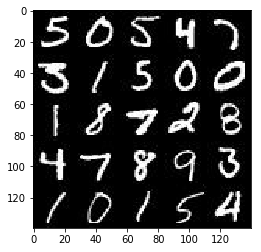

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

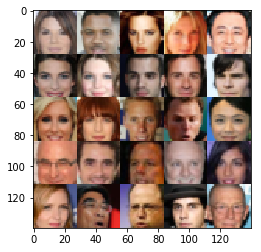

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name = 'input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, None, name = 'learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, keep_prob = 0.9):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flat = tf.reshape(x3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, keep_prob = 0.9):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # shape = 7x7x512
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        g2 = tf.nn.dropout(g2, keep_prob=keep_prob)
        # shape = 14x14x256
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        g3 = tf.nn.dropout(g3, keep_prob=keep_prob)
        # shape = 28x28x128
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='same', activation=None)
        # shape = 28x28x5
        
        out = tf.tanh(logits)
        
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    d_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    g_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


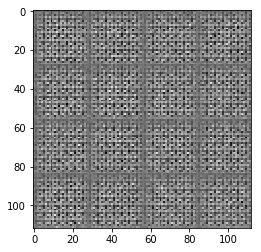

Epoch 1/2... Generator Loss: 3.5016 Discriminator Loss: 0.4326...
Epoch 1/2... Generator Loss: 5.4860 Discriminator Loss: 0.3677...
Epoch 1/2... Generator Loss: 3.6839 Discriminator Loss: 0.4044...
Epoch 1/2... Generator Loss: 0.1672 Discriminator Loss: 2.6204...
Epoch 1/2... Generator Loss: 1.6174 Discriminator Loss: 1.4026...
Epoch 1/2... Generator Loss: 2.0423 Discriminator Loss: 1.1505...
Epoch 1/2... Generator Loss: 1.2148 Discriminator Loss: 1.0962...
Epoch 1/2... Generator Loss: 1.5150 Discriminator Loss: 1.1020...
Epoch 1/2... Generator Loss: 1.7704 Discriminator Loss: 1.1291...
Epoch 1/2... Generator Loss: 0.8429 Discriminator Loss: 1.2343...


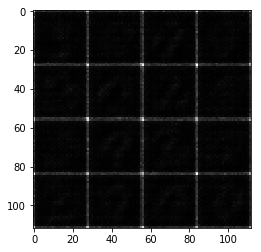

Epoch 1/2... Generator Loss: 1.3800 Discriminator Loss: 1.0851...
Epoch 1/2... Generator Loss: 1.2287 Discriminator Loss: 1.0318...
Epoch 1/2... Generator Loss: 1.0492 Discriminator Loss: 1.2101...
Epoch 1/2... Generator Loss: 1.0143 Discriminator Loss: 1.0829...
Epoch 1/2... Generator Loss: 1.9928 Discriminator Loss: 1.2034...
Epoch 1/2... Generator Loss: 0.8537 Discriminator Loss: 1.1919...
Epoch 1/2... Generator Loss: 1.9522 Discriminator Loss: 1.1079...
Epoch 1/2... Generator Loss: 1.6292 Discriminator Loss: 0.9849...
Epoch 1/2... Generator Loss: 0.9777 Discriminator Loss: 1.0738...
Epoch 1/2... Generator Loss: 1.6587 Discriminator Loss: 0.9258...


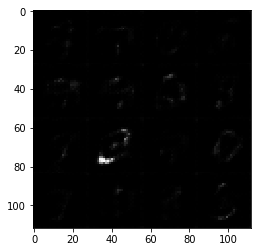

Epoch 1/2... Generator Loss: 1.5028 Discriminator Loss: 1.0687...
Epoch 1/2... Generator Loss: 1.0070 Discriminator Loss: 0.9952...
Epoch 1/2... Generator Loss: 1.9049 Discriminator Loss: 0.9535...
Epoch 1/2... Generator Loss: 1.7321 Discriminator Loss: 0.9521...
Epoch 1/2... Generator Loss: 1.1945 Discriminator Loss: 0.9211...
Epoch 1/2... Generator Loss: 1.1097 Discriminator Loss: 0.9532...
Epoch 1/2... Generator Loss: 1.1778 Discriminator Loss: 0.9905...
Epoch 1/2... Generator Loss: 1.5093 Discriminator Loss: 1.0411...
Epoch 1/2... Generator Loss: 1.1608 Discriminator Loss: 0.9836...
Epoch 1/2... Generator Loss: 1.6368 Discriminator Loss: 1.1424...


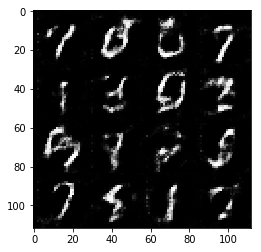

Epoch 1/2... Generator Loss: 0.8273 Discriminator Loss: 1.2099...
Epoch 1/2... Generator Loss: 1.1506 Discriminator Loss: 0.9609...
Epoch 1/2... Generator Loss: 0.8335 Discriminator Loss: 1.0882...
Epoch 1/2... Generator Loss: 0.5817 Discriminator Loss: 1.3606...
Epoch 1/2... Generator Loss: 0.8694 Discriminator Loss: 1.0724...
Epoch 1/2... Generator Loss: 1.4268 Discriminator Loss: 1.0095...
Epoch 1/2... Generator Loss: 0.9067 Discriminator Loss: 1.0457...
Epoch 1/2... Generator Loss: 0.8344 Discriminator Loss: 1.1437...
Epoch 1/2... Generator Loss: 0.8777 Discriminator Loss: 1.1161...
Epoch 1/2... Generator Loss: 0.7722 Discriminator Loss: 1.2137...


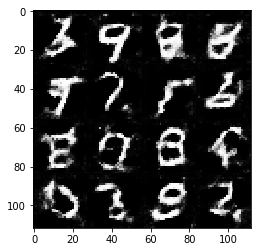

Epoch 1/2... Generator Loss: 0.8715 Discriminator Loss: 1.1424...
Epoch 1/2... Generator Loss: 0.9383 Discriminator Loss: 1.0907...
Epoch 1/2... Generator Loss: 1.6529 Discriminator Loss: 1.0430...
Epoch 1/2... Generator Loss: 0.8779 Discriminator Loss: 1.1241...
Epoch 1/2... Generator Loss: 1.2754 Discriminator Loss: 1.0335...
Epoch 1/2... Generator Loss: 1.6887 Discriminator Loss: 1.0545...
Epoch 2/2... Generator Loss: 1.3159 Discriminator Loss: 0.9956...
Epoch 2/2... Generator Loss: 0.7865 Discriminator Loss: 1.2037...
Epoch 2/2... Generator Loss: 1.3766 Discriminator Loss: 1.0204...
Epoch 2/2... Generator Loss: 1.4510 Discriminator Loss: 1.0832...


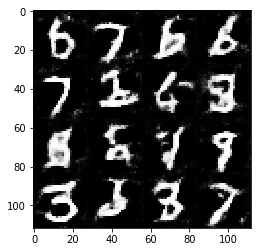

Epoch 2/2... Generator Loss: 1.2503 Discriminator Loss: 1.0737...
Epoch 2/2... Generator Loss: 1.0071 Discriminator Loss: 1.0870...
Epoch 2/2... Generator Loss: 1.3596 Discriminator Loss: 1.0578...
Epoch 2/2... Generator Loss: 0.9761 Discriminator Loss: 1.0748...
Epoch 2/2... Generator Loss: 0.7279 Discriminator Loss: 1.1889...
Epoch 2/2... Generator Loss: 0.6950 Discriminator Loss: 1.2378...
Epoch 2/2... Generator Loss: 1.5688 Discriminator Loss: 1.0241...
Epoch 2/2... Generator Loss: 1.2465 Discriminator Loss: 1.0494...
Epoch 2/2... Generator Loss: 1.1968 Discriminator Loss: 1.0381...
Epoch 2/2... Generator Loss: 0.7338 Discriminator Loss: 1.2303...


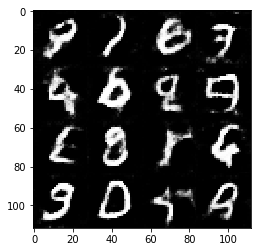

Epoch 2/2... Generator Loss: 1.5393 Discriminator Loss: 1.0298...
Epoch 2/2... Generator Loss: 1.9651 Discriminator Loss: 1.0374...
Epoch 2/2... Generator Loss: 1.2919 Discriminator Loss: 1.0171...
Epoch 2/2... Generator Loss: 1.0617 Discriminator Loss: 1.0471...
Epoch 2/2... Generator Loss: 0.9604 Discriminator Loss: 1.0966...
Epoch 2/2... Generator Loss: 1.0889 Discriminator Loss: 0.9839...
Epoch 2/2... Generator Loss: 0.4866 Discriminator Loss: 1.5268...
Epoch 2/2... Generator Loss: 1.1692 Discriminator Loss: 1.0098...
Epoch 2/2... Generator Loss: 0.5938 Discriminator Loss: 1.3477...
Epoch 2/2... Generator Loss: 1.6841 Discriminator Loss: 1.0057...


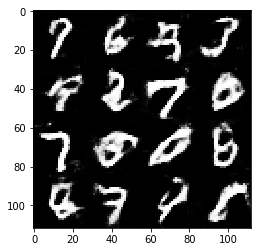

Epoch 2/2... Generator Loss: 0.7878 Discriminator Loss: 1.1447...
Epoch 2/2... Generator Loss: 0.8427 Discriminator Loss: 1.1407...
Epoch 2/2... Generator Loss: 0.9739 Discriminator Loss: 1.1054...
Epoch 2/2... Generator Loss: 0.9800 Discriminator Loss: 1.0376...
Epoch 2/2... Generator Loss: 0.7154 Discriminator Loss: 1.2803...
Epoch 2/2... Generator Loss: 0.7924 Discriminator Loss: 1.1547...
Epoch 2/2... Generator Loss: 0.7072 Discriminator Loss: 1.1973...
Epoch 2/2... Generator Loss: 0.9372 Discriminator Loss: 1.0665...
Epoch 2/2... Generator Loss: 2.2378 Discriminator Loss: 1.2613...
Epoch 2/2... Generator Loss: 0.9241 Discriminator Loss: 1.0917...


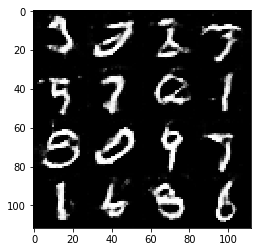

Epoch 2/2... Generator Loss: 0.9247 Discriminator Loss: 1.0779...
Epoch 2/2... Generator Loss: 2.3581 Discriminator Loss: 1.3968...
Epoch 2/2... Generator Loss: 1.1657 Discriminator Loss: 1.0164...
Epoch 2/2... Generator Loss: 1.1931 Discriminator Loss: 0.9657...
Epoch 2/2... Generator Loss: 0.8048 Discriminator Loss: 1.0970...
Epoch 2/2... Generator Loss: 0.9903 Discriminator Loss: 1.0555...
Epoch 2/2... Generator Loss: 1.6426 Discriminator Loss: 1.0566...
Epoch 2/2... Generator Loss: 1.8029 Discriminator Loss: 0.9682...
Epoch 2/2... Generator Loss: 1.1216 Discriminator Loss: 1.0168...
Epoch 2/2... Generator Loss: 0.8288 Discriminator Loss: 1.0729...


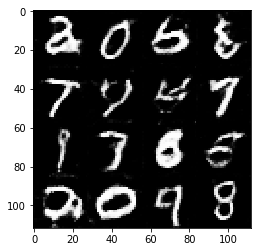

Epoch 2/2... Generator Loss: 0.7349 Discriminator Loss: 1.0959...
Epoch 2/2... Generator Loss: 1.4190 Discriminator Loss: 0.9914...
Epoch 2/2... Generator Loss: 1.2053 Discriminator Loss: 0.9371...


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


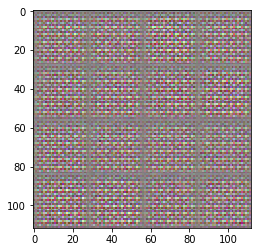

Epoch 1/1... Generator Loss: 5.5257 Discriminator Loss: 0.5120...
Epoch 1/1... Generator Loss: 5.5473 Discriminator Loss: 0.4496...
Epoch 1/1... Generator Loss: 18.2691 Discriminator Loss: 0.5870...
Epoch 1/1... Generator Loss: 18.8773 Discriminator Loss: 0.4653...
Epoch 1/1... Generator Loss: 5.1236 Discriminator Loss: 0.4055...
Epoch 1/1... Generator Loss: 0.5466 Discriminator Loss: 1.5054...
Epoch 1/1... Generator Loss: 3.2623 Discriminator Loss: 0.8041...
Epoch 1/1... Generator Loss: 2.0881 Discriminator Loss: 0.7061...
Epoch 1/1... Generator Loss: 1.4271 Discriminator Loss: 0.7793...
Epoch 1/1... Generator Loss: 2.7615 Discriminator Loss: 0.5703...


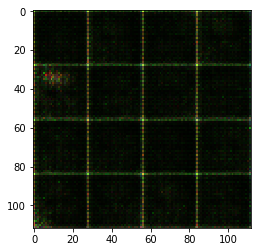

Epoch 1/1... Generator Loss: 2.9022 Discriminator Loss: 0.5276...
Epoch 1/1... Generator Loss: 3.7623 Discriminator Loss: 0.5294...
Epoch 1/1... Generator Loss: 2.8038 Discriminator Loss: 0.5411...
Epoch 1/1... Generator Loss: 2.4761 Discriminator Loss: 0.6110...
Epoch 1/1... Generator Loss: 0.7937 Discriminator Loss: 1.0797...
Epoch 1/1... Generator Loss: 1.0113 Discriminator Loss: 0.9228...
Epoch 1/1... Generator Loss: 1.1496 Discriminator Loss: 1.0775...
Epoch 1/1... Generator Loss: 1.1848 Discriminator Loss: 1.0144...
Epoch 1/1... Generator Loss: 1.9645 Discriminator Loss: 1.0010...
Epoch 1/1... Generator Loss: 2.0594 Discriminator Loss: 1.4275...


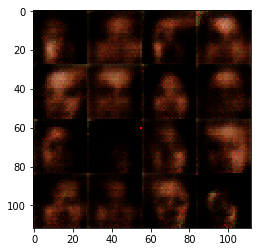

Epoch 1/1... Generator Loss: 2.9248 Discriminator Loss: 2.1661...
Epoch 1/1... Generator Loss: 0.7106 Discriminator Loss: 1.3050...
Epoch 1/1... Generator Loss: 0.9830 Discriminator Loss: 1.2050...
Epoch 1/1... Generator Loss: 0.7452 Discriminator Loss: 1.2768...
Epoch 1/1... Generator Loss: 2.0876 Discriminator Loss: 1.1759...
Epoch 1/1... Generator Loss: 1.7877 Discriminator Loss: 1.2461...
Epoch 1/1... Generator Loss: 1.2406 Discriminator Loss: 1.0238...
Epoch 1/1... Generator Loss: 2.3839 Discriminator Loss: 1.1847...
Epoch 1/1... Generator Loss: 0.8884 Discriminator Loss: 1.2776...
Epoch 1/1... Generator Loss: 0.9785 Discriminator Loss: 0.9415...


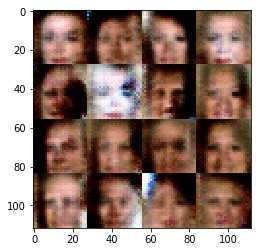

Epoch 1/1... Generator Loss: 0.3049 Discriminator Loss: 1.9223...
Epoch 1/1... Generator Loss: 0.7913 Discriminator Loss: 1.2066...
Epoch 1/1... Generator Loss: 1.7803 Discriminator Loss: 0.8954...
Epoch 1/1... Generator Loss: 0.9413 Discriminator Loss: 1.0404...
Epoch 1/1... Generator Loss: 2.0539 Discriminator Loss: 1.1722...
Epoch 1/1... Generator Loss: 1.4746 Discriminator Loss: 0.9249...
Epoch 1/1... Generator Loss: 0.8100 Discriminator Loss: 1.1926...
Epoch 1/1... Generator Loss: 0.7890 Discriminator Loss: 1.1995...
Epoch 1/1... Generator Loss: 0.5794 Discriminator Loss: 1.3619...
Epoch 1/1... Generator Loss: 0.4154 Discriminator Loss: 1.5294...


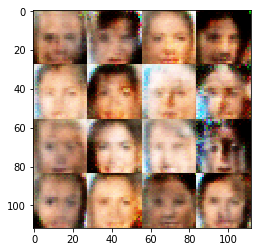

Epoch 1/1... Generator Loss: 1.8364 Discriminator Loss: 1.0345...
Epoch 1/1... Generator Loss: 1.1047 Discriminator Loss: 0.9995...
Epoch 1/1... Generator Loss: 0.4939 Discriminator Loss: 1.4496...
Epoch 1/1... Generator Loss: 0.5343 Discriminator Loss: 1.3859...
Epoch 1/1... Generator Loss: 1.9156 Discriminator Loss: 1.1813...
Epoch 1/1... Generator Loss: 1.8760 Discriminator Loss: 1.0662...
Epoch 1/1... Generator Loss: 1.5167 Discriminator Loss: 1.0589...
Epoch 1/1... Generator Loss: 1.0990 Discriminator Loss: 1.0587...
Epoch 1/1... Generator Loss: 0.8550 Discriminator Loss: 1.2644...
Epoch 1/1... Generator Loss: 0.7496 Discriminator Loss: 1.1948...


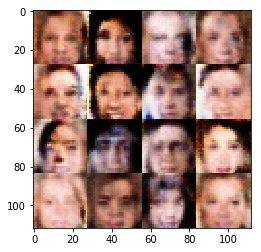

Epoch 1/1... Generator Loss: 1.4305 Discriminator Loss: 1.1909...
Epoch 1/1... Generator Loss: 1.2560 Discriminator Loss: 1.1431...
Epoch 1/1... Generator Loss: 1.3303 Discriminator Loss: 1.1328...
Epoch 1/1... Generator Loss: 0.5315 Discriminator Loss: 1.4401...
Epoch 1/1... Generator Loss: 1.8191 Discriminator Loss: 1.3041...
Epoch 1/1... Generator Loss: 0.9176 Discriminator Loss: 1.2719...
Epoch 1/1... Generator Loss: 1.7793 Discriminator Loss: 1.2941...
Epoch 1/1... Generator Loss: 1.7811 Discriminator Loss: 0.9816...
Epoch 1/1... Generator Loss: 0.7338 Discriminator Loss: 1.3456...
Epoch 1/1... Generator Loss: 1.3345 Discriminator Loss: 1.2205...


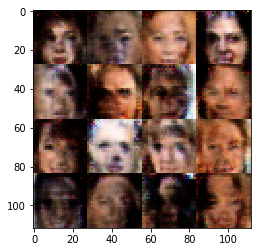

Epoch 1/1... Generator Loss: 1.0569 Discriminator Loss: 1.2140...
Epoch 1/1... Generator Loss: 1.8038 Discriminator Loss: 1.1816...
Epoch 1/1... Generator Loss: 0.9550 Discriminator Loss: 1.1696...
Epoch 1/1... Generator Loss: 0.8150 Discriminator Loss: 1.1188...
Epoch 1/1... Generator Loss: 1.0006 Discriminator Loss: 1.0730...
Epoch 1/1... Generator Loss: 0.8271 Discriminator Loss: 1.2063...
Epoch 1/1... Generator Loss: 0.5288 Discriminator Loss: 1.4380...
Epoch 1/1... Generator Loss: 1.0137 Discriminator Loss: 1.0657...
Epoch 1/1... Generator Loss: 1.5240 Discriminator Loss: 1.1883...
Epoch 1/1... Generator Loss: 0.8798 Discriminator Loss: 1.1248...


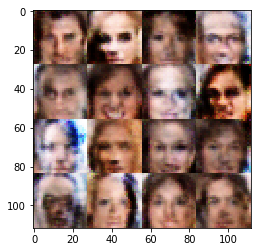

Epoch 1/1... Generator Loss: 1.2350 Discriminator Loss: 1.1632...
Epoch 1/1... Generator Loss: 0.7230 Discriminator Loss: 1.2894...
Epoch 1/1... Generator Loss: 0.9279 Discriminator Loss: 1.2027...
Epoch 1/1... Generator Loss: 0.8014 Discriminator Loss: 1.3170...
Epoch 1/1... Generator Loss: 1.1384 Discriminator Loss: 1.1415...
Epoch 1/1... Generator Loss: 0.7608 Discriminator Loss: 1.3463...
Epoch 1/1... Generator Loss: 1.2401 Discriminator Loss: 0.9909...
Epoch 1/1... Generator Loss: 0.6975 Discriminator Loss: 1.2745...
Epoch 1/1... Generator Loss: 0.8878 Discriminator Loss: 1.2604...
Epoch 1/1... Generator Loss: 0.5117 Discriminator Loss: 1.4789...


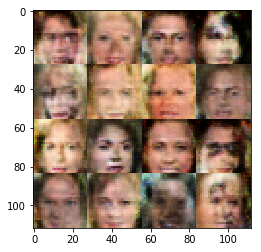

Epoch 1/1... Generator Loss: 0.8936 Discriminator Loss: 1.1615...
Epoch 1/1... Generator Loss: 0.4952 Discriminator Loss: 1.4790...
Epoch 1/1... Generator Loss: 0.7126 Discriminator Loss: 1.3381...
Epoch 1/1... Generator Loss: 1.0786 Discriminator Loss: 1.3584...
Epoch 1/1... Generator Loss: 1.0321 Discriminator Loss: 1.0270...
Epoch 1/1... Generator Loss: 1.7587 Discriminator Loss: 1.5257...
Epoch 1/1... Generator Loss: 0.6530 Discriminator Loss: 1.2375...
Epoch 1/1... Generator Loss: 1.2677 Discriminator Loss: 1.2984...
Epoch 1/1... Generator Loss: 1.0224 Discriminator Loss: 1.1094...
Epoch 1/1... Generator Loss: 0.5839 Discriminator Loss: 1.3801...


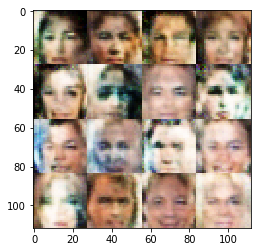

Epoch 1/1... Generator Loss: 0.8815 Discriminator Loss: 1.3118...
Epoch 1/1... Generator Loss: 0.7788 Discriminator Loss: 1.3120...
Epoch 1/1... Generator Loss: 1.2965 Discriminator Loss: 1.0752...
Epoch 1/1... Generator Loss: 0.6213 Discriminator Loss: 1.4221...
Epoch 1/1... Generator Loss: 0.9348 Discriminator Loss: 1.2229...
Epoch 1/1... Generator Loss: 0.6849 Discriminator Loss: 1.4487...
Epoch 1/1... Generator Loss: 0.8302 Discriminator Loss: 1.2879...
Epoch 1/1... Generator Loss: 0.7229 Discriminator Loss: 1.4225...
Epoch 1/1... Generator Loss: 0.7782 Discriminator Loss: 1.3216...
Epoch 1/1... Generator Loss: 0.6644 Discriminator Loss: 1.4069...


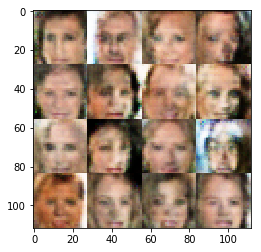

Epoch 1/1... Generator Loss: 1.0383 Discriminator Loss: 1.2304...
Epoch 1/1... Generator Loss: 0.7321 Discriminator Loss: 1.2155...
Epoch 1/1... Generator Loss: 0.7869 Discriminator Loss: 1.3360...
Epoch 1/1... Generator Loss: 0.7939 Discriminator Loss: 1.3385...
Epoch 1/1... Generator Loss: 0.7850 Discriminator Loss: 1.4197...
Epoch 1/1... Generator Loss: 0.9162 Discriminator Loss: 1.2753...
Epoch 1/1... Generator Loss: 1.3095 Discriminator Loss: 1.1965...
Epoch 1/1... Generator Loss: 0.9542 Discriminator Loss: 1.2014...
Epoch 1/1... Generator Loss: 0.9044 Discriminator Loss: 1.3725...
Epoch 1/1... Generator Loss: 1.0314 Discriminator Loss: 1.2076...


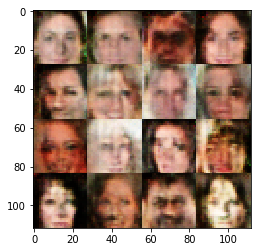

Epoch 1/1... Generator Loss: 0.8821 Discriminator Loss: 1.2741...
Epoch 1/1... Generator Loss: 0.6325 Discriminator Loss: 1.5318...
Epoch 1/1... Generator Loss: 0.7792 Discriminator Loss: 1.2499...
Epoch 1/1... Generator Loss: 1.0408 Discriminator Loss: 1.4119...
Epoch 1/1... Generator Loss: 0.7472 Discriminator Loss: 1.3437...
Epoch 1/1... Generator Loss: 0.6794 Discriminator Loss: 1.3683...
Epoch 1/1... Generator Loss: 0.8158 Discriminator Loss: 1.3215...
Epoch 1/1... Generator Loss: 0.9622 Discriminator Loss: 1.3882...
Epoch 1/1... Generator Loss: 0.6562 Discriminator Loss: 1.2671...
Epoch 1/1... Generator Loss: 0.8309 Discriminator Loss: 1.4155...


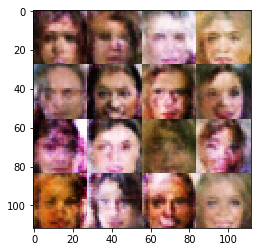

Epoch 1/1... Generator Loss: 0.7657 Discriminator Loss: 1.5409...
Epoch 1/1... Generator Loss: 0.6937 Discriminator Loss: 1.4418...
Epoch 1/1... Generator Loss: 0.9126 Discriminator Loss: 1.3975...
Epoch 1/1... Generator Loss: 0.7617 Discriminator Loss: 1.2286...
Epoch 1/1... Generator Loss: 0.6474 Discriminator Loss: 1.3159...
Epoch 1/1... Generator Loss: 0.5400 Discriminator Loss: 1.4738...
Epoch 1/1... Generator Loss: 1.1374 Discriminator Loss: 1.1343...
Epoch 1/1... Generator Loss: 0.7876 Discriminator Loss: 1.4421...
Epoch 1/1... Generator Loss: 0.8701 Discriminator Loss: 1.3781...
Epoch 1/1... Generator Loss: 0.6187 Discriminator Loss: 1.3892...


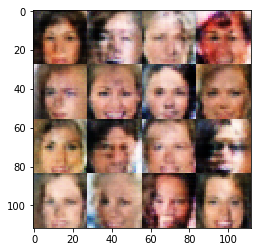

Epoch 1/1... Generator Loss: 0.7379 Discriminator Loss: 1.2686...
Epoch 1/1... Generator Loss: 0.5952 Discriminator Loss: 1.5269...
Epoch 1/1... Generator Loss: 0.6901 Discriminator Loss: 1.4431...
Epoch 1/1... Generator Loss: 0.7472 Discriminator Loss: 1.3352...
Epoch 1/1... Generator Loss: 0.9975 Discriminator Loss: 1.2937...
Epoch 1/1... Generator Loss: 1.2012 Discriminator Loss: 1.4291...
Epoch 1/1... Generator Loss: 0.7089 Discriminator Loss: 1.3483...
Epoch 1/1... Generator Loss: 0.9792 Discriminator Loss: 1.3421...
Epoch 1/1... Generator Loss: 0.6767 Discriminator Loss: 1.4366...
Epoch 1/1... Generator Loss: 0.7905 Discriminator Loss: 1.2153...


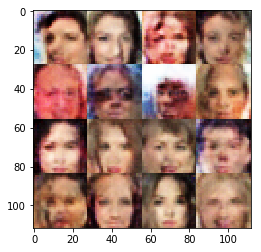

Epoch 1/1... Generator Loss: 0.7971 Discriminator Loss: 1.2663...
Epoch 1/1... Generator Loss: 0.6805 Discriminator Loss: 1.4158...
Epoch 1/1... Generator Loss: 0.8024 Discriminator Loss: 1.3098...
Epoch 1/1... Generator Loss: 0.5980 Discriminator Loss: 1.4685...
Epoch 1/1... Generator Loss: 0.9196 Discriminator Loss: 1.3551...
Epoch 1/1... Generator Loss: 0.4752 Discriminator Loss: 1.5094...
Epoch 1/1... Generator Loss: 0.8359 Discriminator Loss: 1.4091...
Epoch 1/1... Generator Loss: 1.0539 Discriminator Loss: 1.3024...
Epoch 1/1... Generator Loss: 0.8659 Discriminator Loss: 1.4232...
Epoch 1/1... Generator Loss: 0.7452 Discriminator Loss: 1.3373...


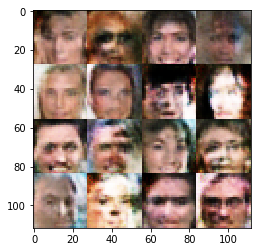

Epoch 1/1... Generator Loss: 1.0484 Discriminator Loss: 1.0889...
Epoch 1/1... Generator Loss: 0.8977 Discriminator Loss: 1.3286...
Epoch 1/1... Generator Loss: 1.1662 Discriminator Loss: 1.0997...
Epoch 1/1... Generator Loss: 0.7205 Discriminator Loss: 1.3394...
Epoch 1/1... Generator Loss: 0.7341 Discriminator Loss: 1.3070...
Epoch 1/1... Generator Loss: 0.9849 Discriminator Loss: 1.2412...
Epoch 1/1... Generator Loss: 0.7460 Discriminator Loss: 1.3335...
Epoch 1/1... Generator Loss: 0.9756 Discriminator Loss: 1.1416...
Epoch 1/1... Generator Loss: 0.7840 Discriminator Loss: 1.3759...
Epoch 1/1... Generator Loss: 0.8645 Discriminator Loss: 1.3684...


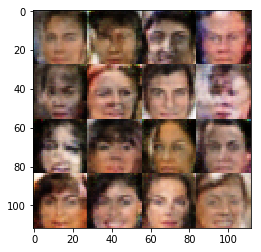

Epoch 1/1... Generator Loss: 0.7823 Discriminator Loss: 1.3017...
Epoch 1/1... Generator Loss: 0.8285 Discriminator Loss: 1.2665...
Epoch 1/1... Generator Loss: 0.7639 Discriminator Loss: 1.2878...
Epoch 1/1... Generator Loss: 0.8926 Discriminator Loss: 1.2140...
Epoch 1/1... Generator Loss: 0.9982 Discriminator Loss: 1.2385...
Epoch 1/1... Generator Loss: 0.7238 Discriminator Loss: 1.3035...
Epoch 1/1... Generator Loss: 0.9839 Discriminator Loss: 1.2381...
Epoch 1/1... Generator Loss: 0.7107 Discriminator Loss: 1.2883...
Epoch 1/1... Generator Loss: 0.9975 Discriminator Loss: 1.2892...
Epoch 1/1... Generator Loss: 0.8000 Discriminator Loss: 1.2845...


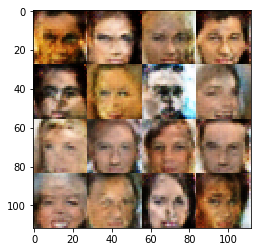

Epoch 1/1... Generator Loss: 0.5850 Discriminator Loss: 1.4816...
Epoch 1/1... Generator Loss: 0.9091 Discriminator Loss: 1.1925...
Epoch 1/1... Generator Loss: 0.8197 Discriminator Loss: 1.3262...
Epoch 1/1... Generator Loss: 1.0252 Discriminator Loss: 1.2548...
Epoch 1/1... Generator Loss: 0.8489 Discriminator Loss: 1.3665...
Epoch 1/1... Generator Loss: 0.7843 Discriminator Loss: 1.3467...
Epoch 1/1... Generator Loss: 0.5179 Discriminator Loss: 1.5462...
Epoch 1/1... Generator Loss: 0.8148 Discriminator Loss: 1.3199...
Epoch 1/1... Generator Loss: 0.4856 Discriminator Loss: 1.6907...
Epoch 1/1... Generator Loss: 0.8134 Discriminator Loss: 1.3440...


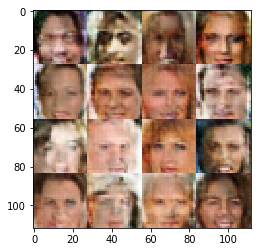

Epoch 1/1... Generator Loss: 0.7659 Discriminator Loss: 1.3307...
Epoch 1/1... Generator Loss: 0.8091 Discriminator Loss: 1.3011...
Epoch 1/1... Generator Loss: 1.1189 Discriminator Loss: 1.3013...
Epoch 1/1... Generator Loss: 0.9667 Discriminator Loss: 1.3036...
Epoch 1/1... Generator Loss: 0.8535 Discriminator Loss: 1.3728...
Epoch 1/1... Generator Loss: 0.7961 Discriminator Loss: 1.4867...
Epoch 1/1... Generator Loss: 0.9467 Discriminator Loss: 1.3085...
Epoch 1/1... Generator Loss: 0.8073 Discriminator Loss: 1.2620...
Epoch 1/1... Generator Loss: 0.8331 Discriminator Loss: 1.3013...
Epoch 1/1... Generator Loss: 0.5409 Discriminator Loss: 1.4367...


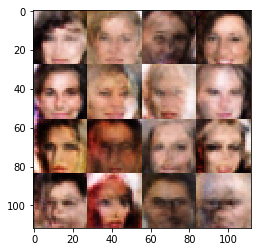

Epoch 1/1... Generator Loss: 0.8773 Discriminator Loss: 1.2618...
Epoch 1/1... Generator Loss: 0.7379 Discriminator Loss: 1.3598...
Epoch 1/1... Generator Loss: 0.6843 Discriminator Loss: 1.4298...
Epoch 1/1... Generator Loss: 0.7373 Discriminator Loss: 1.2803...
Epoch 1/1... Generator Loss: 0.8323 Discriminator Loss: 1.4409...
Epoch 1/1... Generator Loss: 1.0146 Discriminator Loss: 1.4323...
Epoch 1/1... Generator Loss: 0.7246 Discriminator Loss: 1.4534...
Epoch 1/1... Generator Loss: 0.7041 Discriminator Loss: 1.3512...
Epoch 1/1... Generator Loss: 0.6171 Discriminator Loss: 1.4042...
Epoch 1/1... Generator Loss: 0.7829 Discriminator Loss: 1.4339...


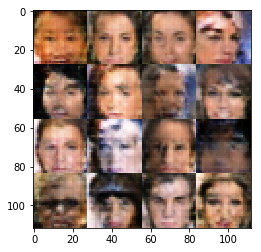

Epoch 1/1... Generator Loss: 0.8876 Discriminator Loss: 1.3051...
Epoch 1/1... Generator Loss: 0.8463 Discriminator Loss: 1.2252...
Epoch 1/1... Generator Loss: 1.0921 Discriminator Loss: 1.2931...
Epoch 1/1... Generator Loss: 0.7767 Discriminator Loss: 1.3275...
Epoch 1/1... Generator Loss: 0.7515 Discriminator Loss: 1.3489...
Epoch 1/1... Generator Loss: 0.8686 Discriminator Loss: 1.3208...
Epoch 1/1... Generator Loss: 0.7455 Discriminator Loss: 1.3674...
Epoch 1/1... Generator Loss: 0.9931 Discriminator Loss: 1.2299...
Epoch 1/1... Generator Loss: 0.8745 Discriminator Loss: 1.2702...
Epoch 1/1... Generator Loss: 1.0780 Discriminator Loss: 1.2503...


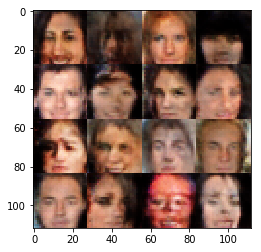

Epoch 1/1... Generator Loss: 0.7677 Discriminator Loss: 1.3205...
Epoch 1/1... Generator Loss: 0.6812 Discriminator Loss: 1.4411...
Epoch 1/1... Generator Loss: 0.5948 Discriminator Loss: 1.3907...
Epoch 1/1... Generator Loss: 0.7763 Discriminator Loss: 1.3239...
Epoch 1/1... Generator Loss: 0.6703 Discriminator Loss: 1.3566...
Epoch 1/1... Generator Loss: 0.9129 Discriminator Loss: 1.2650...
Epoch 1/1... Generator Loss: 0.8711 Discriminator Loss: 1.2528...
Epoch 1/1... Generator Loss: 0.8627 Discriminator Loss: 1.2525...
Epoch 1/1... Generator Loss: 0.8697 Discriminator Loss: 1.2928...
Epoch 1/1... Generator Loss: 0.7631 Discriminator Loss: 1.3693...


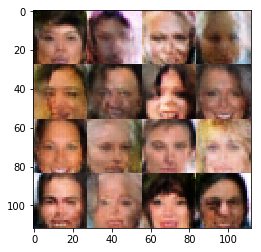

Epoch 1/1... Generator Loss: 0.9916 Discriminator Loss: 1.3521...
Epoch 1/1... Generator Loss: 0.8267 Discriminator Loss: 1.3515...
Epoch 1/1... Generator Loss: 0.7391 Discriminator Loss: 1.3400...
Epoch 1/1... Generator Loss: 0.8729 Discriminator Loss: 1.2795...
Epoch 1/1... Generator Loss: 0.7160 Discriminator Loss: 1.2684...
Epoch 1/1... Generator Loss: 0.9811 Discriminator Loss: 1.2420...
Epoch 1/1... Generator Loss: 0.9663 Discriminator Loss: 1.1677...
Epoch 1/1... Generator Loss: 0.7101 Discriminator Loss: 1.4460...
Epoch 1/1... Generator Loss: 0.7524 Discriminator Loss: 1.4367...
Epoch 1/1... Generator Loss: 0.7800 Discriminator Loss: 1.3545...


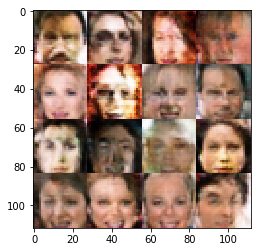

Epoch 1/1... Generator Loss: 0.7670 Discriminator Loss: 1.2998...
Epoch 1/1... Generator Loss: 0.9509 Discriminator Loss: 1.3133...
Epoch 1/1... Generator Loss: 0.7054 Discriminator Loss: 1.3302...
Epoch 1/1... Generator Loss: 0.8188 Discriminator Loss: 1.3484...
Epoch 1/1... Generator Loss: 0.5797 Discriminator Loss: 1.3792...
Epoch 1/1... Generator Loss: 0.8704 Discriminator Loss: 1.2793...
Epoch 1/1... Generator Loss: 0.8478 Discriminator Loss: 1.2985...
Epoch 1/1... Generator Loss: 0.8353 Discriminator Loss: 1.2620...
Epoch 1/1... Generator Loss: 0.6221 Discriminator Loss: 1.4077...
Epoch 1/1... Generator Loss: 0.8475 Discriminator Loss: 1.3214...


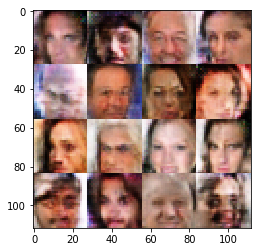

Epoch 1/1... Generator Loss: 0.8891 Discriminator Loss: 1.3159...
Epoch 1/1... Generator Loss: 0.9422 Discriminator Loss: 1.2460...
Epoch 1/1... Generator Loss: 0.9587 Discriminator Loss: 1.2671...
Epoch 1/1... Generator Loss: 0.7690 Discriminator Loss: 1.3788...
Epoch 1/1... Generator Loss: 0.9771 Discriminator Loss: 1.3248...
Epoch 1/1... Generator Loss: 0.5222 Discriminator Loss: 1.4860...
Epoch 1/1... Generator Loss: 0.8763 Discriminator Loss: 1.2462...
Epoch 1/1... Generator Loss: 0.7489 Discriminator Loss: 1.3126...
Epoch 1/1... Generator Loss: 0.8918 Discriminator Loss: 1.3030...
Epoch 1/1... Generator Loss: 0.8381 Discriminator Loss: 1.2727...


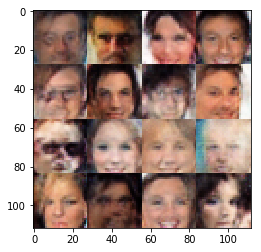

Epoch 1/1... Generator Loss: 0.8788 Discriminator Loss: 1.2810...
Epoch 1/1... Generator Loss: 1.0872 Discriminator Loss: 1.2498...
Epoch 1/1... Generator Loss: 0.7496 Discriminator Loss: 1.3194...
Epoch 1/1... Generator Loss: 0.8770 Discriminator Loss: 1.2891...
Epoch 1/1... Generator Loss: 0.8589 Discriminator Loss: 1.3010...
Epoch 1/1... Generator Loss: 0.7309 Discriminator Loss: 1.3323...
Epoch 1/1... Generator Loss: 0.6668 Discriminator Loss: 1.4236...
Epoch 1/1... Generator Loss: 0.7322 Discriminator Loss: 1.3601...
Epoch 1/1... Generator Loss: 1.0160 Discriminator Loss: 1.2095...
Epoch 1/1... Generator Loss: 1.0981 Discriminator Loss: 1.2220...


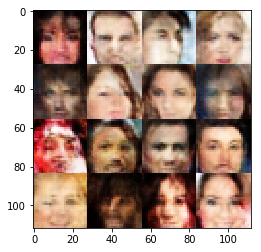

Epoch 1/1... Generator Loss: 0.8202 Discriminator Loss: 1.2745...
Epoch 1/1... Generator Loss: 0.7073 Discriminator Loss: 1.3052...
Epoch 1/1... Generator Loss: 1.0105 Discriminator Loss: 1.2265...
Epoch 1/1... Generator Loss: 0.9157 Discriminator Loss: 1.3647...
Epoch 1/1... Generator Loss: 0.7540 Discriminator Loss: 1.3797...
Epoch 1/1... Generator Loss: 0.8123 Discriminator Loss: 1.2195...
Epoch 1/1... Generator Loss: 0.8244 Discriminator Loss: 1.3234...
Epoch 1/1... Generator Loss: 0.7307 Discriminator Loss: 1.4285...
Epoch 1/1... Generator Loss: 0.7986 Discriminator Loss: 1.2475...
Epoch 1/1... Generator Loss: 1.0812 Discriminator Loss: 1.3035...


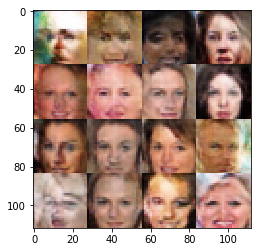

Epoch 1/1... Generator Loss: 1.0950 Discriminator Loss: 1.2492...
Epoch 1/1... Generator Loss: 0.9105 Discriminator Loss: 1.2371...
Epoch 1/1... Generator Loss: 0.7103 Discriminator Loss: 1.4174...
Epoch 1/1... Generator Loss: 0.7332 Discriminator Loss: 1.3544...
Epoch 1/1... Generator Loss: 0.8251 Discriminator Loss: 1.3430...
Epoch 1/1... Generator Loss: 0.8304 Discriminator Loss: 1.3753...
Epoch 1/1... Generator Loss: 0.7090 Discriminator Loss: 1.3331...
Epoch 1/1... Generator Loss: 0.8872 Discriminator Loss: 1.2025...
Epoch 1/1... Generator Loss: 0.7709 Discriminator Loss: 1.3654...
Epoch 1/1... Generator Loss: 0.7645 Discriminator Loss: 1.3893...


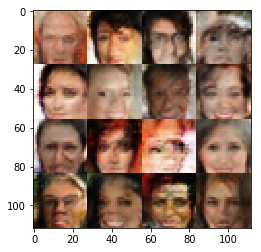

Epoch 1/1... Generator Loss: 0.7788 Discriminator Loss: 1.2887...
Epoch 1/1... Generator Loss: 0.9827 Discriminator Loss: 1.1686...
Epoch 1/1... Generator Loss: 0.7944 Discriminator Loss: 1.3972...
Epoch 1/1... Generator Loss: 0.9444 Discriminator Loss: 1.2779...
Epoch 1/1... Generator Loss: 1.0275 Discriminator Loss: 1.2697...
Epoch 1/1... Generator Loss: 0.8468 Discriminator Loss: 1.3388...
Epoch 1/1... Generator Loss: 0.6728 Discriminator Loss: 1.3408...
Epoch 1/1... Generator Loss: 1.1462 Discriminator Loss: 1.2475...
Epoch 1/1... Generator Loss: 0.9258 Discriminator Loss: 1.2123...
Epoch 1/1... Generator Loss: 0.8043 Discriminator Loss: 1.3513...


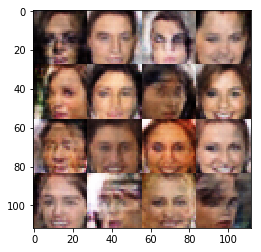

Epoch 1/1... Generator Loss: 0.8500 Discriminator Loss: 1.3554...
Epoch 1/1... Generator Loss: 0.8683 Discriminator Loss: 1.3252...
Epoch 1/1... Generator Loss: 0.9848 Discriminator Loss: 1.2765...
Epoch 1/1... Generator Loss: 0.9000 Discriminator Loss: 1.1886...
Epoch 1/1... Generator Loss: 0.7866 Discriminator Loss: 1.3154...
Epoch 1/1... Generator Loss: 0.6613 Discriminator Loss: 1.3299...
Epoch 1/1... Generator Loss: 0.8422 Discriminator Loss: 1.2632...
Epoch 1/1... Generator Loss: 0.7957 Discriminator Loss: 1.2753...
Epoch 1/1... Generator Loss: 0.9070 Discriminator Loss: 1.3472...
Epoch 1/1... Generator Loss: 0.6053 Discriminator Loss: 1.4080...


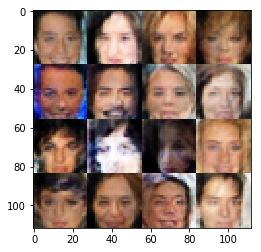

Epoch 1/1... Generator Loss: 0.6764 Discriminator Loss: 1.3547...
Epoch 1/1... Generator Loss: 0.9175 Discriminator Loss: 1.3744...
Epoch 1/1... Generator Loss: 0.9294 Discriminator Loss: 1.1929...
Epoch 1/1... Generator Loss: 1.0361 Discriminator Loss: 1.3492...
Epoch 1/1... Generator Loss: 0.9569 Discriminator Loss: 1.2030...
Epoch 1/1... Generator Loss: 1.0817 Discriminator Loss: 1.1587...
Epoch 1/1... Generator Loss: 0.7365 Discriminator Loss: 1.3683...
Epoch 1/1... Generator Loss: 0.9675 Discriminator Loss: 1.4047...
Epoch 1/1... Generator Loss: 1.0307 Discriminator Loss: 1.3288...
Epoch 1/1... Generator Loss: 0.8394 Discriminator Loss: 1.2912...


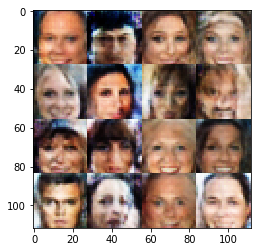

Epoch 1/1... Generator Loss: 0.7616 Discriminator Loss: 1.2772...
Epoch 1/1... Generator Loss: 0.7366 Discriminator Loss: 1.2635...
Epoch 1/1... Generator Loss: 0.8645 Discriminator Loss: 1.4269...
Epoch 1/1... Generator Loss: 0.7574 Discriminator Loss: 1.3494...
Epoch 1/1... Generator Loss: 0.7776 Discriminator Loss: 1.2824...
Epoch 1/1... Generator Loss: 0.6505 Discriminator Loss: 1.4668...


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.